# Machine Learning Modelling

In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import time

In [48]:
# Load dataset
data = pd.read_csv('./data/Cleaned_data.csv')

## *Feature Engineering*

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21745 entries, 0 to 21744
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           21745 non-null  object 
 1   City            21745 non-null  object 
 2   Street          21745 non-null  object 
 3   Zipcode         21745 non-null  int64  
 4   Bedroom         21745 non-null  float64
 5   Bathroom        21745 non-null  float64
 6   Area            21745 non-null  float64
 7   PPSq            21745 non-null  float64
 8   LotArea         21745 non-null  float64
 9   MarketEstimate  21745 non-null  float64
 10  RentEstimate    21745 non-null  float64
 11  Latitude        21745 non-null  float64
 12  Longitude       21745 non-null  float64
 13  ListedPrice     21745 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 2.3+ MB


In [50]:
# Function to split Zipcode into individual components
def split_zipcode(zipcode):
    str_zip = str(zipcode).zfill(5)
    return [int(str_zip[0]), int(str_zip[1]), int(str_zip[2]), int(str_zip[3]), int(str_zip[4])]

zipcode_components = data['Zipcode'].apply(split_zipcode)
zipcode_df = pd.DataFrame(zipcode_components.tolist(), columns=['NationalArea', 'CityPO1', 'CityPO2', 'AssociatePO1', 'AssociatePO2'])

df = pd.concat([data, zipcode_df], axis=1)

In [52]:
df.sort_values(by='Zipcode')

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,Latitude,Longitude,ListedPrice,NationalArea,CityPO1,CityPO2,AssociatePO1,AssociatePO2
9237,MA,Amherst,Sunderland Rd,1002,4.0,3.0,3120.0,181.089744,2.700000,526800.000000,3499.0,42.422096,-72.538150,565000.0,0,1,0,0,2
8926,MA,Belchertown,Gold St,1007,3.0,2.0,1296.0,270.061728,1.730000,355000.000000,2949.0,42.342020,-72.410630,350000.0,0,1,0,0,7
8804,MA,Belchertown,Mill Valley Rd,1007,3.0,2.0,1512.0,210.978836,1.760000,324600.000000,2274.0,42.263100,-72.374750,319000.0,0,1,0,0,7
8812,MA,Chester,Maple St,1011,5.0,2.0,2136.0,46.816479,0.450000,88900.000000,2800.0,42.278910,-72.979530,100000.0,0,1,0,1,1
8915,MA,Chicopee,Fairmont St,1013,2.0,1.0,1008.0,237.996032,0.511387,242000.000000,1800.0,42.185658,-72.598274,239900.0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,AK,Ketchikan,Schoenbar Rd,99901,4.0,3.0,2112.0,233.428030,0.340000,475400.000000,1949.0,55.347317,-131.637570,493000.0,9,9,9,0,1
516,AK,Coffman Cove,Coho Dr,99918,3.0,3.0,1850.0,539.459459,0.400000,942680.641922,2585.0,56.021515,-132.827740,998000.0,9,9,9,1,8
685,AK,Coffman Cove,NE Minke,99918,1.0,1.0,1200.0,290.833333,3.900000,346900.000000,1900.0,56.012170,-132.810640,349000.0,9,9,9,1,8
751,AK,Wrangell,.2 Mile Zimovia Hwy,99929,3.0,2.0,1800.0,206.666667,0.980000,370600.000000,2500.0,56.363064,-132.356580,372000.0,9,9,9,2,9


## *Model Training*

In [53]:
# Function to preprocess the data
def preprocess_data(df):
    features = df[['Bedroom', 'Bathroom', 'Area', 'PPSq', 'Longitude', 'Latitude', 
                   'NationalArea', 'CityPO1', 'CityPO2', 'AssociatePO1', 'AssociatePO2']]
    features_for_listed_price = features.copy()
    features_for_rent_estimate = features.copy()

    # Adding cross-target variables
    features_for_listed_price['RentEstimate'] = df['RentEstimate']
    features_for_rent_estimate['ListedPrice'] = df['ListedPrice']

    return features_for_listed_price, features_for_rent_estimate, df['ListedPrice'], df['RentEstimate']

features_for_listed_price, features_for_rent_estimate, y_listed, y_rent = preprocess_data(df)

In [54]:
# Split dataset for ListedPrice and RentEstimate
X_train_listed, X_test_listed, y_train_listed, y_test_listed = train_test_split(features_for_listed_price, y_listed, test_size=0.2, random_state=42)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(features_for_rent_estimate, y_rent, test_size=0.2, random_state=42)

# Separate scalers for each model
scaler_listed = MinMaxScaler()
scaler_rent = MinMaxScaler()

X_train_listed_scaled = scaler_listed.fit_transform(X_train_listed)
X_test_listed_scaled = scaler_listed.transform(X_test_listed)

X_train_rent_scaled = scaler_rent.fit_transform(X_train_rent)
X_test_rent_scaled = scaler_rent.transform(X_test_rent)

In [55]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
}

# Function to evaluate model's performance
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    start_time = time.time()
    cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    cv_rmse = [math.sqrt(-score) for score in cv_rmse_scores]
    cv_rmse_mean = np.mean(cv_rmse)
    cv_r2_mean = np.mean(cv_r2_scores)
    cv_mae_mean = -np.mean(cv_mae_scores)
    
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, cv_rmse_mean, cv_r2_mean, cv_mae_mean, test_rmse, test_r2, test_mae, train_time, prediction_time]

In [56]:
def run_evaluation(X_train, y_train, X_test, y_test):
    results = []
    for name, model in models.items():
        result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
        results.append(result)
    return pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])

print("Evaluating models for ListedPrice...")
results_listed = run_evaluation(X_train_listed_scaled, y_train_listed, X_test_listed_scaled, y_test_listed)

print("\nEvaluating models for RentEstimate...")
results_rent = run_evaluation(X_train_rent_scaled, y_train_rent, X_test_rent_scaled, y_test_rent)

Evaluating models for ListedPrice...
Evaluating LinearRegression...
Evaluating RandomForestRegressor...
Evaluating GradientBoostingRegressor...
Evaluating XGBRegressor...
Evaluating CatBoostRegressor...
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 13916, number of used features: 12
[LightGBM] [Info] Start training from score 546054.813596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 12
[LightGBM] [Info] Start training from score 526935.680032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 12
[LightGBM] [Info] Start training from score 2671.763032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 12
[LightGBM] [Info] Start training from score 2721.319597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 12
[LightGBM] [Info] Sta

In [57]:
# Function to display and sort the results
def display_results(results, target_name):
    results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])
    results_df_sorted = results_df.sort_values(by='Test R-squared')
    return results_df_sorted

results_listed_df = display_results(results_listed, 'ListedPrice')
results_rent_df = display_results(results_rent, 'RentEstimate')

In [58]:
results_listed_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
0,LinearRegression,765891.259120,0.735226,247681.928687,551601.939272,0.793846,234850.054502,0.375771,0.000000
1,RandomForestRegressor,724654.107843,0.757381,46073.720115,414084.390851,0.883823,33673.638144,468.588236,0.289058
3,XGBRegressor,701800.608041,0.787011,54023.738800,403317.535366,0.889786,36680.392433,10.201367,0.032019
4,CatBoostRegressor,635394.922561,0.825964,46868.108619,358579.166259,0.912881,35368.341405,164.887154,0.008003
5,LightGBM,649436.785644,0.818501,51942.882505,318285.272981,0.931361,34689.960615,11.822732,0.022186
2,GradientBoostingRegressor,576717.071355,0.850357,68751.096804,263274.470578,0.953037,59535.685163,121.652950,0.008012


In [59]:
results_rent_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
3,XGBRegressor,2485.501148,0.559990,490.268513,1766.059093,0.743613,464.687966,9.161063,0.008004
0,LinearRegression,2470.727067,0.575334,642.078254,1748.800095,0.748600,613.305989,0.283859,0.000508
2,GradientBoostingRegressor,2416.871671,0.574660,476.782595,1673.871555,0.769681,456.804897,115.072682,0.008274
1,RandomForestRegressor,2396.309769,0.597717,465.556923,1531.338844,0.807235,425.638754,469.844885,0.273032
4,CatBoostRegressor,2217.003418,0.652614,463.137492,1457.397736,0.825401,427.787685,158.858341,0.016006
5,LightGBM,2091.759767,0.688229,468.751890,1442.951800,0.828845,434.273486,12.380872,0.016046


## *Hyperparameter Tuning*

In [20]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define hyperparameter grids
param_grids = {
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 62, 127]
    },
    'CatBoostRegressor': {
        'iterations': [500, 1000],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model_name, model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {-grid_search.best_score_}")
    return grid_search.best_estimator_

# Function to evaluate model performance
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = [math.sqrt(-score) for score in scores]
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    train_time = time.time() - start_time
    
    # Training on the training set
    model.fit(X_train, y_train)
    
    start_time = time.time()
    # Predicting on the test set
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    # Computing test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, np.mean(cv_rmse_scores), np.mean(cv_r2_scores), np.mean(cv_mae_scores), test_rmse, test_r2, test_mae, train_time, prediction_time]

In [21]:
# Perform hyperparameter tuning and evaluation for ListedPrice models
tuned_models_listed = {}
results_listed = []

for model_name in ['GradientBoostingRegressor', 'LightGBM', 'CatBoostRegressor', 'XGBRegressor']:
    tuned_model = hyperparameter_tuning(model_name, models[model_name], param_grids[model_name], X_train_listed_scaled, y_train_listed)
    tuned_models_listed[model_name] = tuned_model
    result = evaluate_model(tuned_model, model_name, X_train_listed_scaled, y_train_listed, X_test_listed_scaled, y_test_listed)
    results_listed.append(result)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best score for GradientBoostingRegressor: 39924.85449869137
Evaluating GradientBoostingRegressor...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 17396, number of used features: 12
[LightGBM] [Info] Start training from score 536621.625489
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 127}
Best score for LightGBM: 48692.68496904965
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seco

In [24]:
# Perform hyperparameter tuning and evaluation for RentEstimate models
tuned_models_rent = {}
results_rent = []

for model_name in ['CatBoostRegressor', 'LightGBM', 'RandomForestRegressor', 'GradientBoostingRegressor']:
    tuned_model = hyperparameter_tuning(model_name, models[model_name], param_grids[model_name], X_train_rent_scaled, y_train_rent)
    tuned_models_rent[model_name] = tuned_model
    result = evaluate_model(tuned_model, model_name, X_train_rent_scaled, y_train_rent, X_test_rent_scaled, y_test_rent)
    results_rent.append(result)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for CatBoostRegressor: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}
Best score for CatBoostRegressor: 459.66976542844515
Evaluating CatBoostRegressor...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 17396, number of used features: 12
[LightGBM] [Info] Start training from score 2711.286607
Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 127}
Best score for LightGBM: 453.06131056161905
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_w

In [25]:
# Function to display and sort the results
def display_results(results, target_name):
    results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])
    results_df_sorted = results_df.sort_values(by='Test MAE')
    print(f"\nResults for {target_name}:")
    print(results_df_sorted)
    return results_df_sorted

# Display and sort the results
results_listed_df = display_results(results_listed, 'ListedPrice')
results_rent_df = display_results(results_rent, 'RentEstimate')


Results for ListedPrice:
                       Model        CV RMSE  CV R-squared        CV MAE  \
0  GradientBoostingRegressor  595873.419150      0.840602  39924.854499   
1                   LightGBM  649021.333034      0.818859  48692.684969   
2          CatBoostRegressor  624255.119419      0.832601  45628.946342   
3               XGBRegressor  701304.200310      0.789509  51568.225969   

       Test RMSE  Test R-squared      Test MAE  Train Time  Prediction Time  
0  266685.429597        0.951812  26569.297660  133.348343         0.012997  
1  321155.038652        0.930117  32379.638654    3.416215         0.005999  
2  366999.453550        0.908742  35460.601079   36.936163         0.001984  
3  390221.670185        0.896828  35724.696530    2.914939         0.002001  

Results for RentEstimate:
                       Model      CV RMSE  CV R-squared      CV MAE  \
2      RandomForestRegressor  2238.934882      0.646460  458.133867   
0          CatBoostRegressor  2226.3766

In [26]:
results_listed_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
0,GradientBoostingRegressor,595873.419150,0.840602,39924.854499,266685.429597,0.951812,26569.297660,133.348343,0.012997
1,LightGBM,649021.333034,0.818859,48692.684969,321155.038652,0.930117,32379.638654,3.416215,0.005999
2,CatBoostRegressor,624255.119419,0.832601,45628.946342,366999.453550,0.908742,35460.601079,36.936163,0.001984
3,XGBRegressor,701304.200310,0.789509,51568.225969,390221.670185,0.896828,35724.696530,2.914939,0.002001


In [27]:
results_rent_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
2,RandomForestRegressor,2238.934882,0.646460,458.133867,1529.025015,0.807817,424.451161,337.443930,0.172506
0,CatBoostRegressor,2226.376659,0.648695,459.669765,1501.196868,0.814749,425.139808,72.376300,0.001981
1,LightGBM,1975.885876,0.730028,453.061311,1462.439618,0.824191,431.387374,11.163306,0.011006
3,GradientBoostingRegressor,2511.813013,0.537799,475.343033,2293.570918,0.567577,464.774998,162.438458,0.013012


## *Saving the model*

In [30]:
import joblib
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

# Best parameters from GridSearchCV
best_params_listed = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
best_params_rent = {'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 127}

# Train the final GradientBoostingRegressor model for ListedPrice
final_model_listed = GradientBoostingRegressor(**best_params_listed)
final_model_listed.fit(X_train_listed_scaled, y_train_listed)

GradientBoostingRegressor(max_depth=4, n_estimators=300)

In [31]:
# Train the final LightGBM model for RentEstimate
final_model_rent = lgb.LGBMRegressor(**best_params_rent)
final_model_rent.fit(X_train_rent_scaled, y_train_rent)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 17396, number of used features: 12
[LightGBM] [Info] Start training from score 2711.286607


LGBMRegressor(learning_rate=0.01, n_estimators=300, num_leaves=127)

In [60]:
# Save the trained models and the scalar fitted
joblib.dump(final_model_listed, 'final_model_listed.pkl')
joblib.dump(final_model_rent, 'final_model_rent.pkl')

joblib.dump(scaler_listed, 'scaler_listed.pkl')
joblib.dump(scaler_rent, 'scaler_rent.pkl')
print("Models and scalers saved successfully!")

Models and scalers saved successfully!


## *Comparing Predictions*

In [61]:
# Gradient Boosting model - Best performing model for Listed Price prediction
y_pred_gbr = final_model_listed.predict(X_test_listed_scaled)
gbr_results = pd.DataFrame({'Actual Listed Price': y_test_listed, 'Predicted Listed Price': y_pred_gbr})
gbr_results['Actual Listed Price'] = gbr_results['Actual Listed Price'].round(2)
gbr_results['Predicted Listed Price'] = gbr_results['Predicted Listed Price'].round(2)
gbr_results.sample(n=5)

,Actual Listed Price,Predicted Listed Price
12897,375000.0,366731.45
10668,374900.0,365055.80
487,186000.0,180445.26
12727,439900.0,438365.84
9136,1895000.0,1836867.65


In [62]:
# LightGBM model - Best performing model for Rent Price prediction
y_pred_lgbm = final_model_rent.predict(X_test_rent_scaled)
lgbm_results = pd.DataFrame({'Actual Rent Price': y_test_rent, 'Predicted Rent Price': y_pred_lgbm})
lgbm_results['Actual Rent Price'] = lgbm_results['Actual Rent Price'].round(2)
lgbm_results['Predicted Rent Price'] = lgbm_results['Predicted Rent Price'].round(2)
lgbm_results.sample(n=5)

,Actual Rent Price,Predicted Rent Price
2981,2500.00,2605.68
2003,1882.00,2098.15
12821,2810.48,2950.96
13259,1867.20,1733.74
13574,1882.14,1725.09


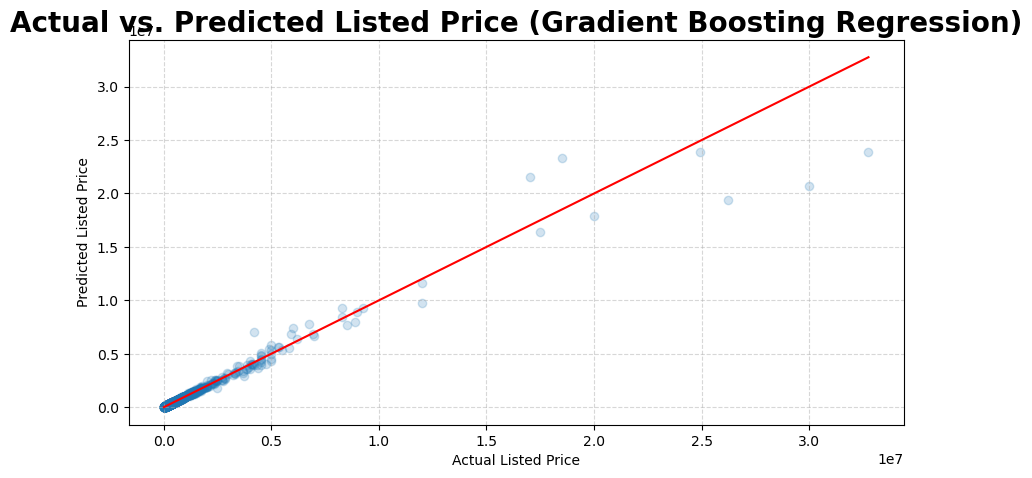

In [45]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot - Actual vs. Predicted Listed price
plt.figure(figsize=(10,5))

plt.scatter(y_test_listed, y_pred_gbr, alpha=0.2)
plt.plot([min(y_test_listed), max(y_test_listed)], [min(y_test_listed), max(y_test_listed)], color='red')

plt.title('Actual vs. Predicted Listed Price (Gradient Boosting Regression)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Listed Price')
plt.ylabel('Predicted Listed Price')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()

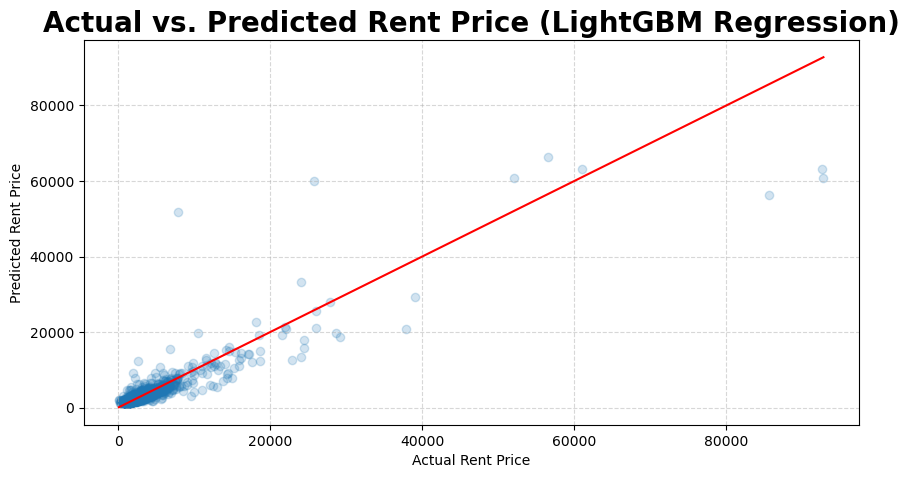

In [44]:
# Scatterplot - Actual vs. Predicted Rent price
plt.figure(figsize=(10,5))

plt.scatter(y_test_rent, y_pred_lgbm, alpha=0.2)
plt.plot([min(y_test_rent), max(y_test_rent)], [min(y_test_rent), max(y_test_rent)], color='red')

plt.title('Actual vs. Predicted Rent Price (LightGBM Regression)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Rent Price')
plt.ylabel('Predicted Rent Price')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()

## *Loading and predicting values*

In [63]:
import joblib

# Load the saved models and scalers
final_model_listed = joblib.load('final_model_listed.pkl')
final_model_rent = joblib.load('final_model_rent.pkl')
scaler_listed = joblib.load('scaler_listed.pkl')
scaler_rent = joblib.load('scaler_rent.pkl')